In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
paths = []
labels = []
label_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
for dirname, _, filenames in os.walk('../RAVDESS_Audio_Speech_Actors_01-24'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('-')[2]
        label = label_map[label]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

print(labels[:10])
print('Dataset is Loaded')

['neutral', 'neutral', 'neutral', 'neutral', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm']
Dataset is Loaded


In [3]:
len(paths), len(labels)

(1440, 1440)

In [4]:
paths[:5], labels[:5]

(['../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-01-01-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-01-02-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-02-01-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-02-02-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-02-01-01-01-01.wav'],
 ['neutral', 'neutral', 'neutral', 'neutral', 'calm'])

In [5]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
1,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
2,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
3,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
4,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,calm


In [6]:
df['label'].value_counts()

label
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

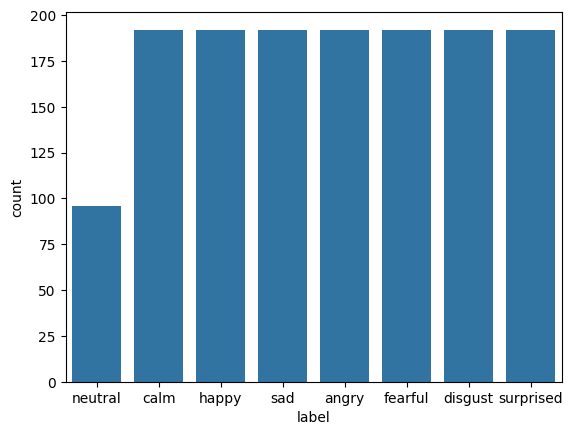

In [7]:
sns.countplot(data=df, x='label')

In [8]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

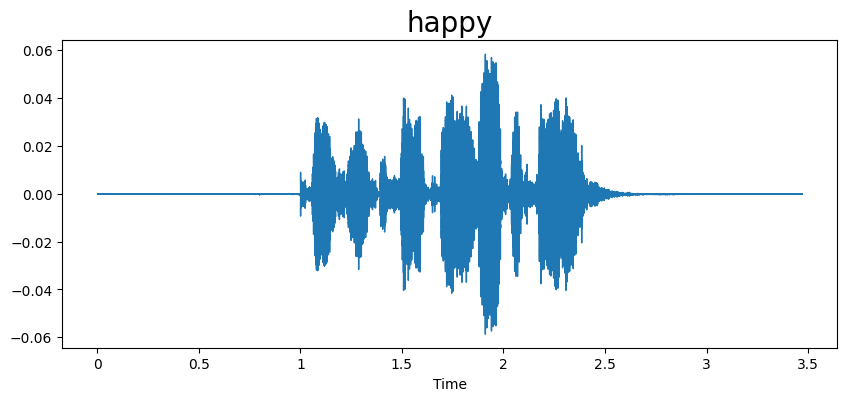

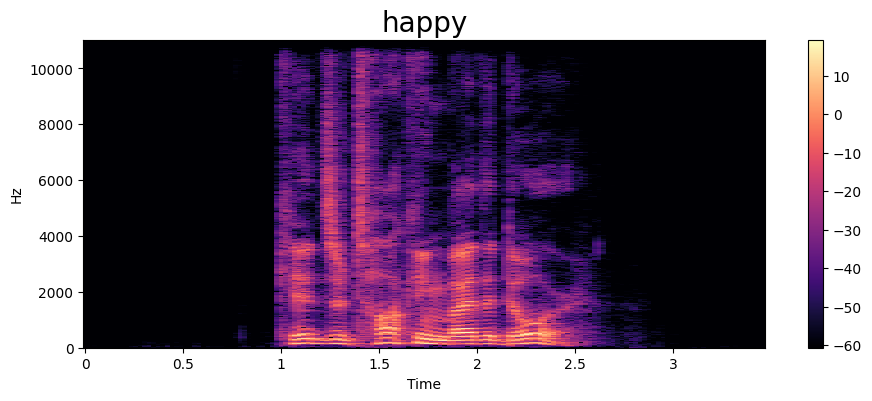

In [9]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [10]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=2.4, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T
    return mfcc

In [11]:
extract_mfcc(df['speech'][10])

array([[-9.46737732e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.46737732e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.44136536e+02,  3.66772413e+00,  3.63487554e+00, ...,
        -3.21665347e-01, -2.95776844e-01, -2.65896916e-01],
       ...,
       [-4.60708344e+02,  1.12948555e+02, -3.43861341e+00, ...,
        -4.52677536e+00, -1.08405437e+01, -4.10197353e+00],
       [-4.73422668e+02,  1.45353821e+02, -2.78018212e+00, ...,
        -5.65316868e+00, -5.33166075e+00, -8.49880028e+00],
       [-4.67365631e+02,  1.38023331e+02,  1.15437040e+01, ...,
        -2.86190462e+00, -3.42082644e+00, -5.52790260e+00]], dtype=float32)

In [12]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [13]:
print(X_mfcc[0].shape)

(104, 40)


In [14]:
X = [x for x in X_mfcc]

In [15]:
length = []
for i, arr in enumerate(X):
    if arr.shape[0] not in length:
        length.append(arr.shape[0]) 
    # print(f"Array {i}: shape={arr.shape}")
print(length)

[104]


In [16]:
X = np.array(X)
X.shape

(1440, 104, 40)

In [17]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [18]:
y = y.toarray()

In [19]:
y.shape

(1440, 8)

In [20]:
enc.categories_

[array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
        'surprised'], dtype=object)]

In [56]:
# LSTM Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
# X_train = np.swapaxes(X_train, 1, 2)
# X_test = np.swapaxes(X_test, 1, 2)
# X_train = np.expand_dims(X_train, axis=3)
# X_test = np.expand_dims(X_test, axis=3)

X_train.shape, X_test.shape

((1152, 104, 40, 1), (288, 104, 40, 1))

In [46]:
input_shape = X_train_exp.shape[1:]

In [66]:

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, TimeDistributed, Flatten, BatchNormalization

model = Sequential([
    TimeDistributed(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(40, 1))),  
    TimeDistributed(Flatten()),
    TimeDistributed(BatchNormalization()), 
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_17             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, mode='min')

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.1773 - loss: 2.0508 - val_accuracy: 0.2847 - val_loss: 1.9131
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3009 - loss: 1.8100 - val_accuracy: 0.3333 - val_loss: 1.8236
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3699 - loss: 1.6897 - val_accuracy: 0.3160 - val_loss: 1.7616
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3880 - loss: 1.5981 - val_accuracy: 0.3993 - val_loss: 1.6967
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4398 - loss: 1.4974 - val_accuracy: 0.3924 - val_loss: 1.6368
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5272 - loss: 1.3419 - val_accuracy: 0.4132 - val_loss: 1.5586
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5597 - loss: 1.2333 - val_accuracy: 0.4757 - val_loss: 1.5420
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6032 - loss: 1.1086 - val_accuracy: 0.4896 - v

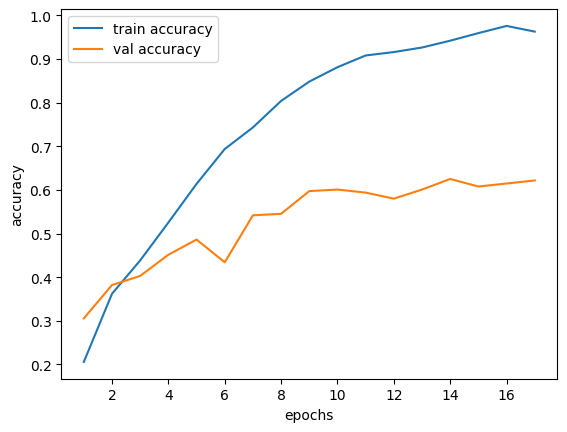

In [59]:
epochs = range(1, len(history.history['accuracy'])+1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

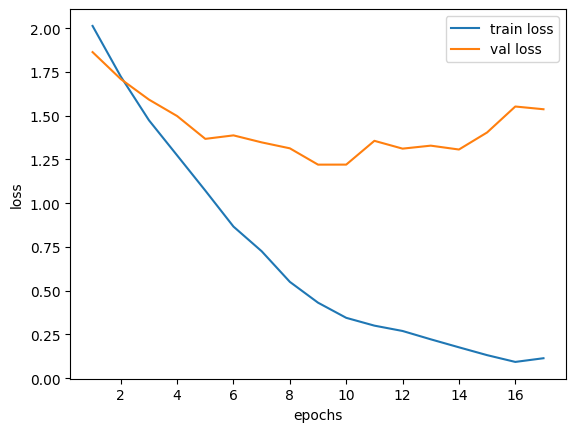

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [61]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

accuracy_score(y_true, y_pred), cm

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


(0.6215277777777778,
 array([[26,  1,  4,  2,  4,  0,  0,  1],
        [ 0, 29,  0,  2,  0,  5,  2,  0],
        [ 4,  1, 23,  2,  2,  1,  5,  1],
        [ 6,  1,  0, 18,  6,  1,  3,  4],
        [ 2,  1,  3,  1, 20,  4,  6,  2],
        [ 0,  3,  0,  0,  0, 14,  2,  0],
        [ 0,  2,  4,  0,  1,  8, 23,  0],
        [ 1,  0,  1,  0,  6,  1,  3, 26]], dtype=int64))

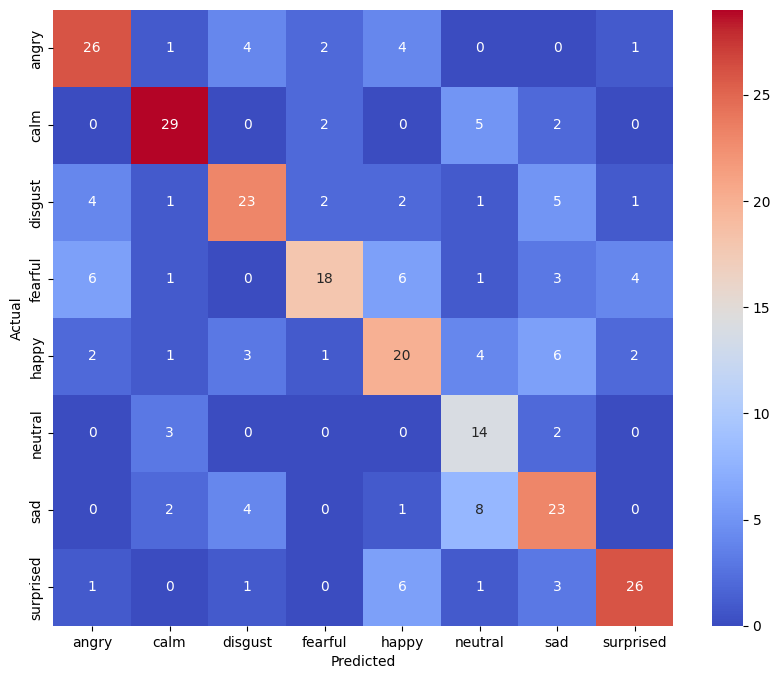

In [62]:
# print colorful confusion matrix
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


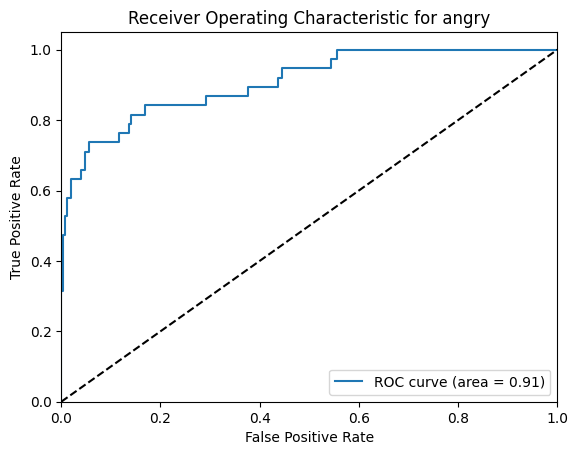

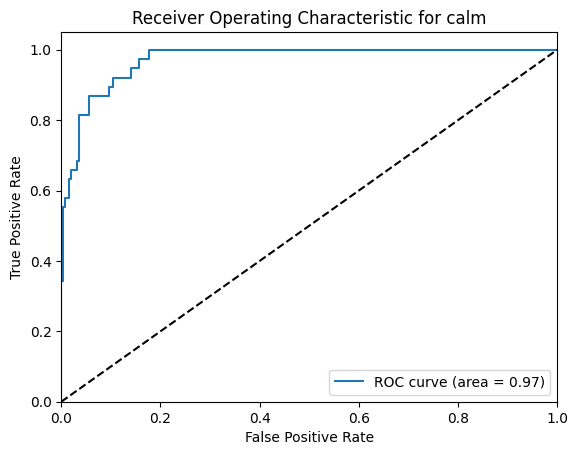

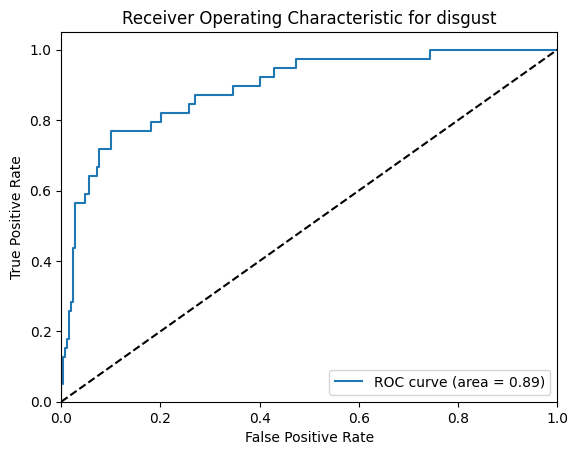

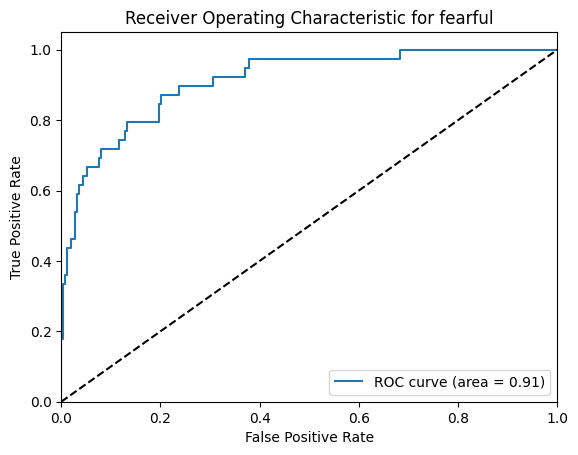

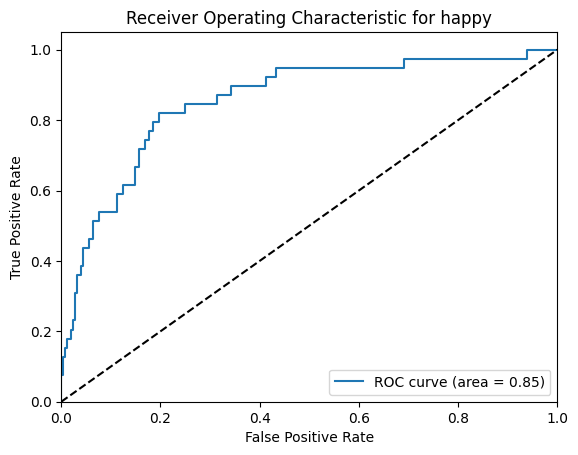

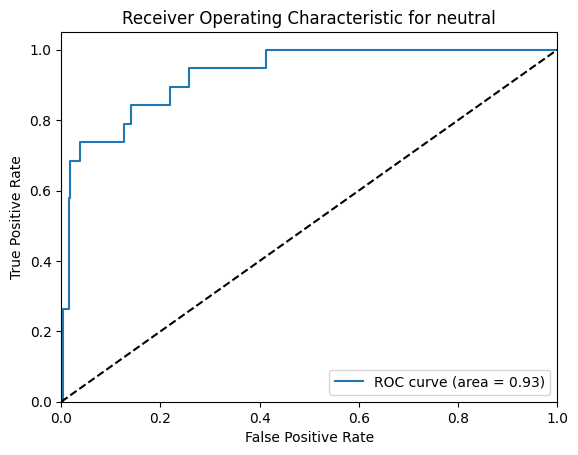

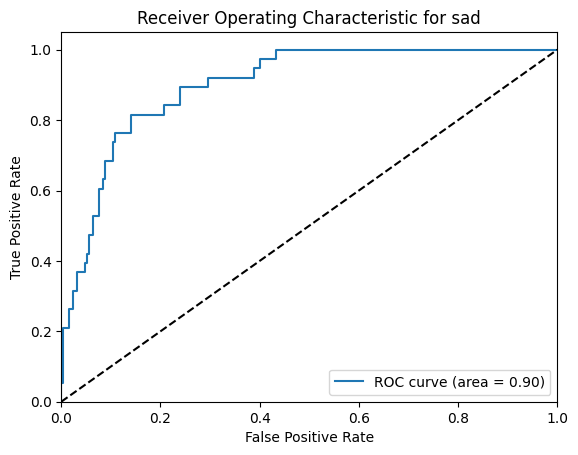

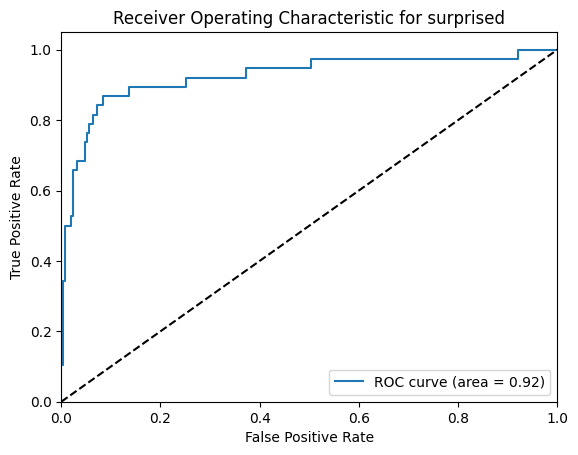

In [63]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

lb = LabelBinarizer()
y_test = lb.fit_transform(y_test)
y_pred = model.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(8):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for '+enc.categories_[0][i])
    plt.legend(loc="lower right")
    plt.show()

In [65]:
# model.save('..\Models\emotion_detection_RAVDESS_LSTM_v3.keras')

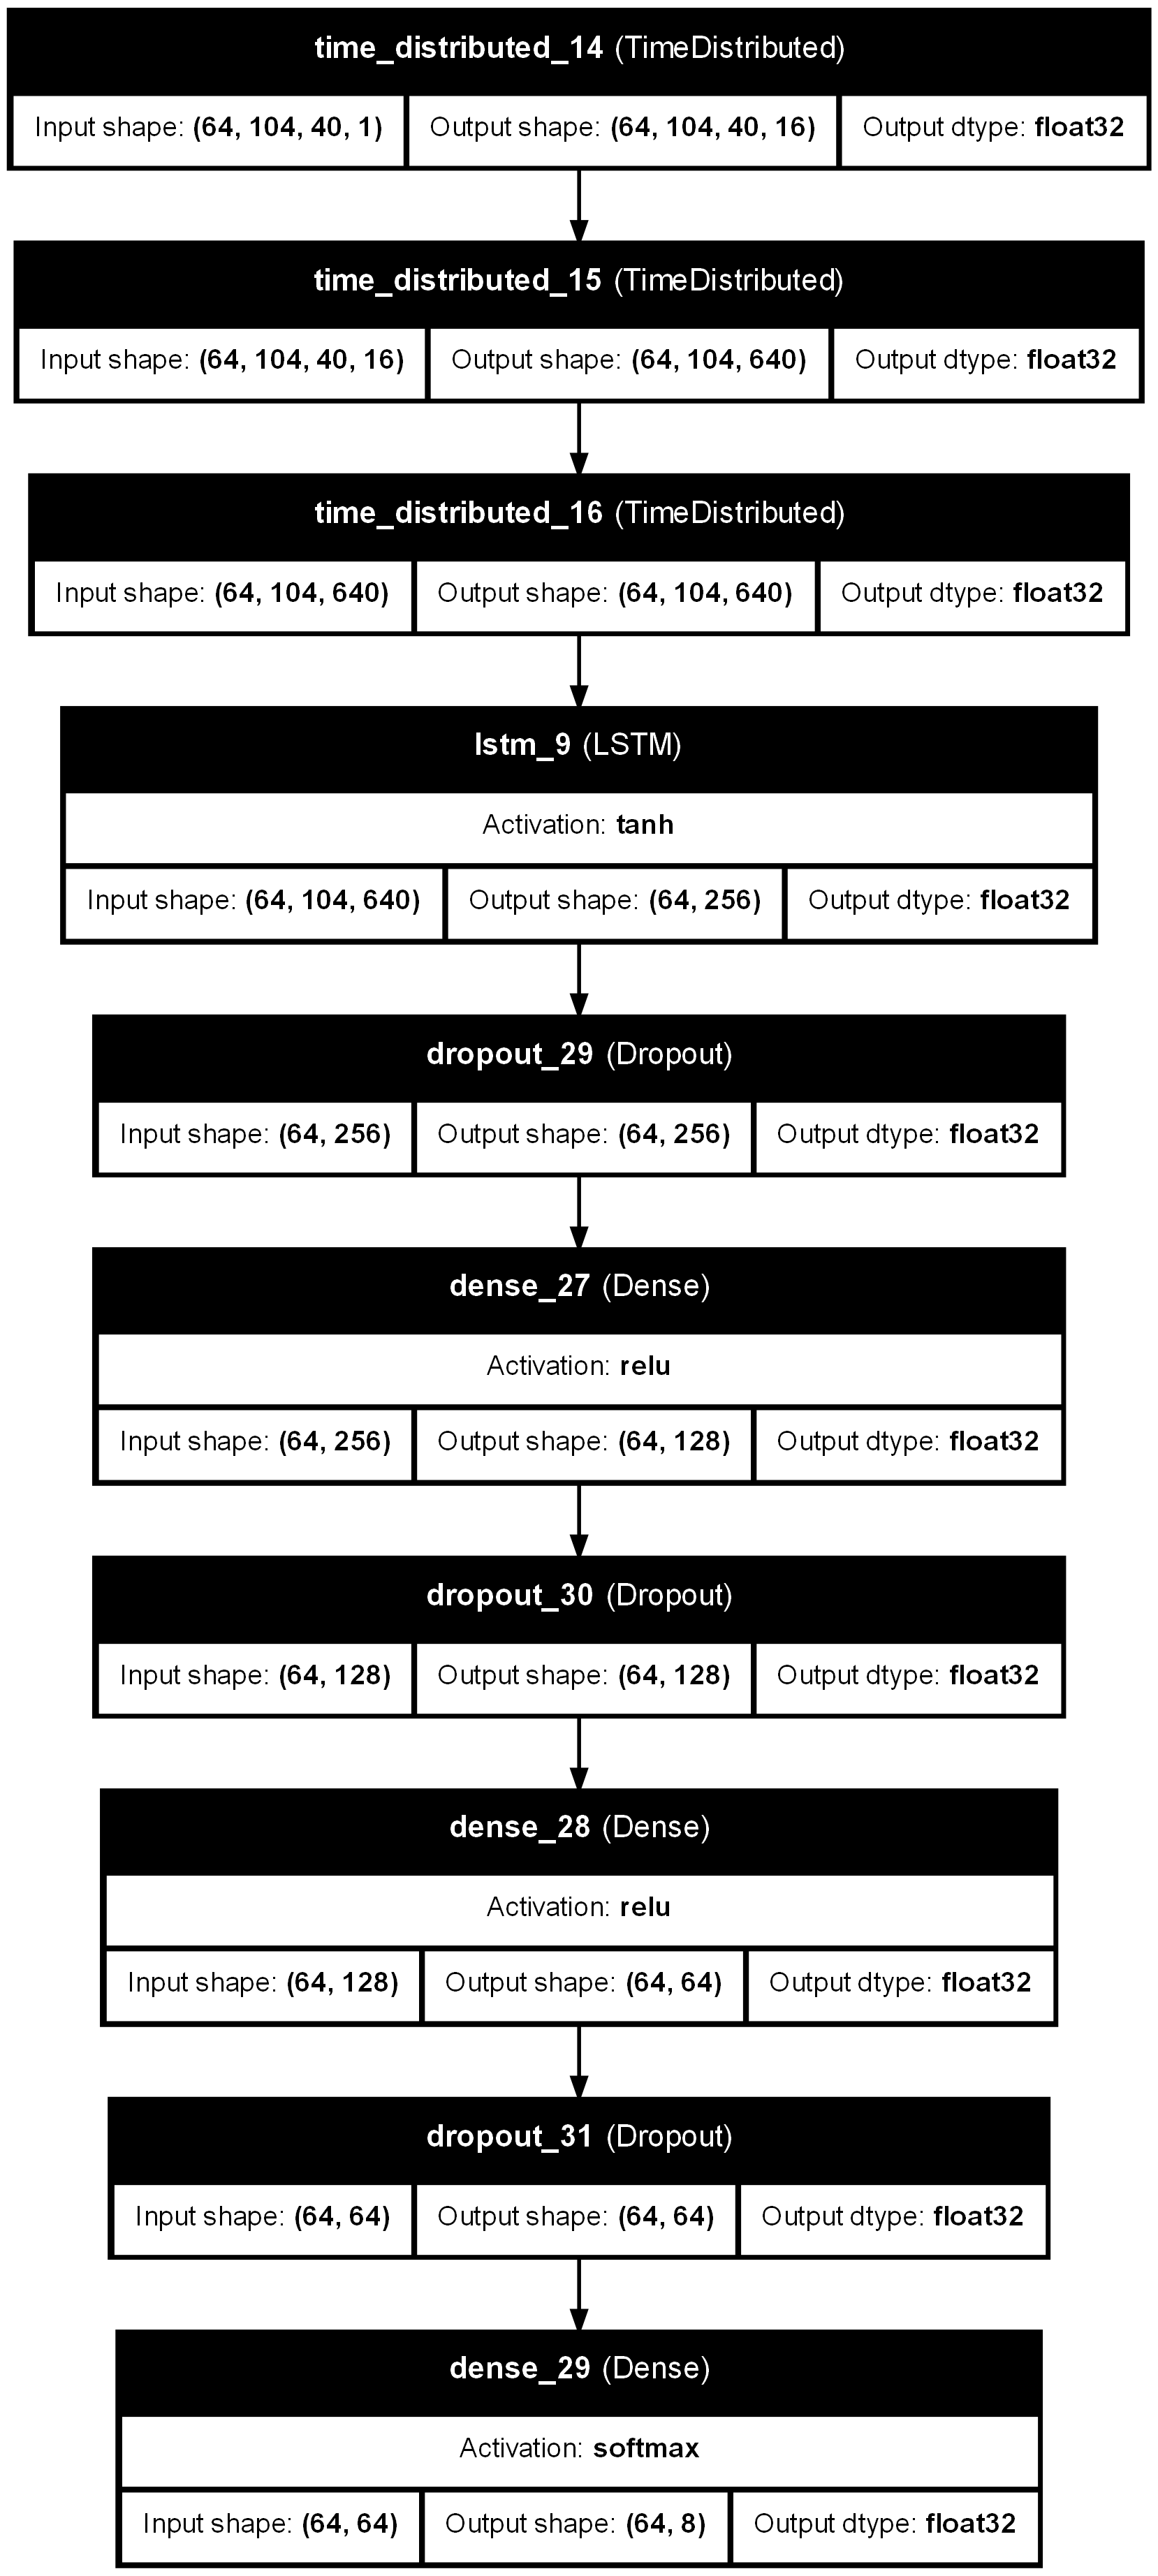

In [64]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)